## 1. Scala's real-world project repository data
<p>Analyzed, cleaned, and visualized the real world project repository of Scala that spans data from a version control system (Git) as well as a project hosting site (GitHub). Analysis was done to find out who has had the most influence on its development and who are the experts.</p>
<p>Datasets:</p>
<ol>
<li><code>pulls_2011-2013.csv</code> contains the basic information about the pull requests, and spans from the end of 2011 up to (but not including) 2014.</li>
<li><code>pulls_2014-2018.csv</code> contains identical information, and spans from 2014 up to 2018.</li>
<li><code>pull_files.csv</code> contains the files that were modified by each pull request.</li>
</ol>

In [12]:
# Importing pandas
import pandas as pd

# Loading in the data
pulls_one = pd.read_csv('datasets/pulls_2011-2013.csv')
pulls_two = pd.read_csv('datasets/pulls_2014-2018.csv')
pull_files = pd.read_csv('datasets/pull_files.csv')

## 2. Preparing and cleaning the data
<p>Combining the data from the two separate pull DataFrames and converting the dates into <code>DateTime</code> objects. </p>

<p>The pull request times are all in UTC (Coordinated Universal Time). The commit times, however, are in the local time of the author with their respective time zone information. To make comparisons easy, the commit times are converetd into UTC.</p>

In [13]:
# Appending pulls_one to pulls_two
pulls = pulls_one.append(pulls_two)

# Converting the date for the pulls object
pulls['date'] = pd.to_datetime(pulls['date'], utc= True)

## 3. Merging the DataFrames
<p>The data extracted comes in two separate files. Merging the two DataFrames for easier analysis.</p>

In [14]:
# Merging the two DataFrames
data = pulls.merge(pull_files, on= 'pid')

## 4. Is the project still actively maintained?
<p>The data used in this project was collected in January of 2018. Analysis is done on the evolution of the number of contributions up to that date.</p>



<AxesSubplot:xlabel='month,year'>

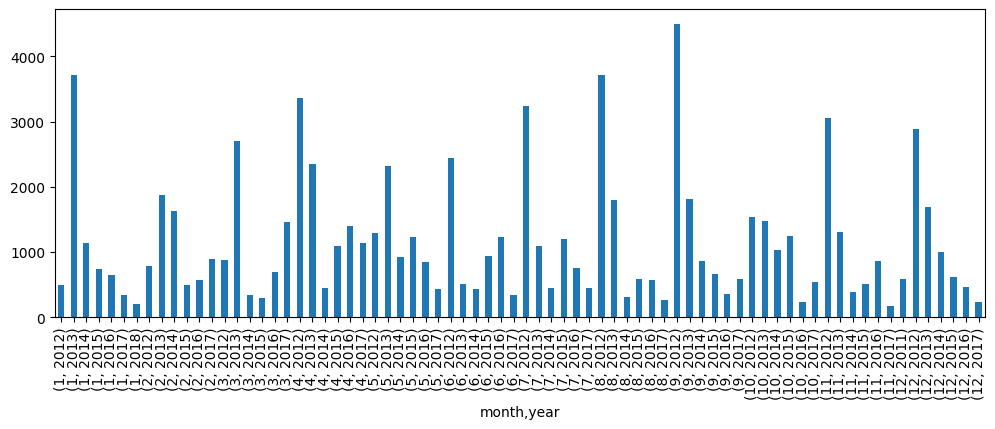

In [15]:
%matplotlib inline

# Creating a column that will store the month
data['month'] = data['date'].dt.month

# Creating a column that will store the year
data['year'] = data['date'].dt.year

# Grouping by the month and year and counting the pull requests
counts = data.groupby(['month','year'])['pid'].count()

# Plotting the results
counts.plot(kind='bar', figsize = (12,4))

## 5. Evaluating the dynamics of the community
<p>Analysis done by plotting a histogram of the number of pull requests submitted by each user.  </p>

<function matplotlib.pyplot.show(close=None, block=None)>

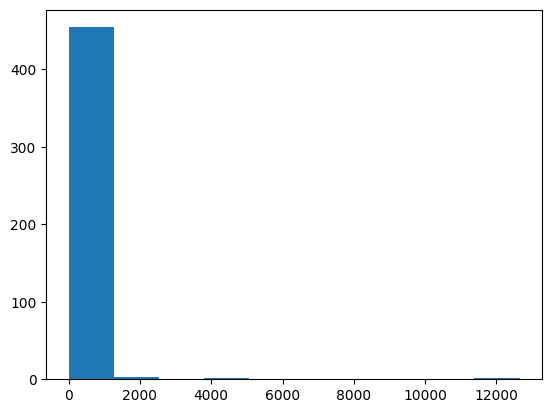

In [16]:
# Required for matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Group by the submitter
by_user = data.groupby('user')['pid'].count()

# Plot the histogram
plt.hist(by_user)
plt.show

## 6. What files were changed in the last ten pull requests?
<p>Finding the "hot" areas of the code where most of the activity is happening.</p>

In [17]:
# Identifying the last 10 pull requests
last_10 = pulls.sort_values(by= 'date').tail(10)

# Joining the two data sets
joined_pr = pull_files.merge(last_10, on= 'pid')

# Identifying the unique files
files = set(joined_pr['file'])

# Printing the results
files

{'LICENSE',
 'doc/LICENSE.md',
 'doc/License.rtf',
 'project/VersionUtil.scala',
 'src/compiler/scala/reflect/reify/phases/Calculate.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/BCodeHelpers.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/PostProcessor.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/analysis/BackendUtils.scala',
 'src/compiler/scala/tools/nsc/profile/AsyncHelper.scala',
 'src/compiler/scala/tools/nsc/profile/Profiler.scala',
 'src/compiler/scala/tools/nsc/symtab/classfile/ClassfileParser.scala',
 'src/compiler/scala/tools/nsc/typechecker/Contexts.scala',
 'src/library/scala/Predef.scala',
 'src/library/scala/concurrent/Lock.scala',
 'src/library/scala/util/Properties.scala',
 'src/reflect/scala/reflect/internal/pickling/ByteCodecs.scala',
 'src/reflect/scala/reflect/internal/tpe/GlbLubs.scala',
 'src/scaladoc/scala/tools/nsc/doc/html/page/Entity.scala',
 'src/scalap/decoder.properties',
 'test/files/neg/leibniz-liskov.check',
 'test/files/neg/leibniz-liskov

## 7. Who made the most pull requests to a given file?

<p>From previous results we can see that the file <code>"src/compiler/scala/reflect/reify/phases/Calculate.scala"</code> has been recently changed. We are interested in the top 3 developers who changed that file and their contribution history.</p>

In [18]:
# File we are interested in:
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Identifying the commits that changed the file
file_pr = data[data['file'] == file]

# Counting the number of changes made by each developer
author_counts = file_pr.groupby('user').count()

# Printing the top 3 developers
print(author_counts.nlargest(3, 'file'))

          pid  date  file  month  year
user                                  
xeno-by    11    11    11     11    11
retronym    5     5     5      5     5
soc         4     4     4      4     4


## 8. Who made the last ten pull requests on a given file?
<p>Looking for the developers that made the last ten pull requests on the file <code>"src/compiler/scala/reflect/reify/phases/Calculate.scala"<code></p>

In [19]:
# File we are interested in:
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Selecting the pull requests that changed the target file
file_pr = pull_files[pull_files['file'] == file]

# Merging the obtained results with the pulls DataFrame
joined_pr = file_pr.merge(pulls, on = 'pid')

# Finding the users of the last 10 most recent pull requests
users_last_10 = set(joined_pr.nlargest(10, 'date')['user'])

# Printing the results
users_last_10

{'bjornregnell', 'retronym', 'soc', 'starblood', 'xeno-by', 'zuvizudar'}

## 9. The pull requests of two special developers
<p>Comparing the contribution of the two developers: xeno-by and soc over the years</p>

<AxesSubplot:xlabel='date'>

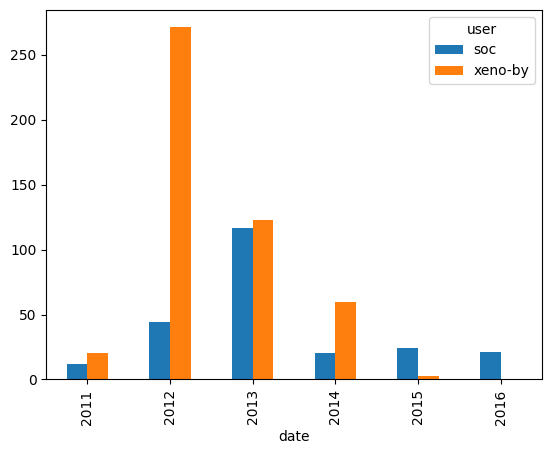

In [20]:
%matplotlib inline

# The developers we are interested in
authors = ['xeno-by', 'soc']

# Extracting all the developers' pull requests
by_author = pulls[pulls['user'].isin(authors)]

# Counting the number of pull requests submitted each year
counts = by_author.groupby(['user', by_author['date'].dt.year]).agg({'pid': 'count'}).reset_index()

# Converting the table to a wide format
counts_wide = counts.pivot_table(index='date', columns='user', values='pid', fill_value=0)

# Plotting the results
counts_wide.plot(kind = 'bar')

## 10. Visualizing the contributions of each developer
<p>Comparing the contributions of the two developers: soc and xeno-by to the file <code>"src/compiler/scala/reflect/reify/phases/Calculate.scala"</code></p> over the years.

<AxesSubplot:xlabel='date'>

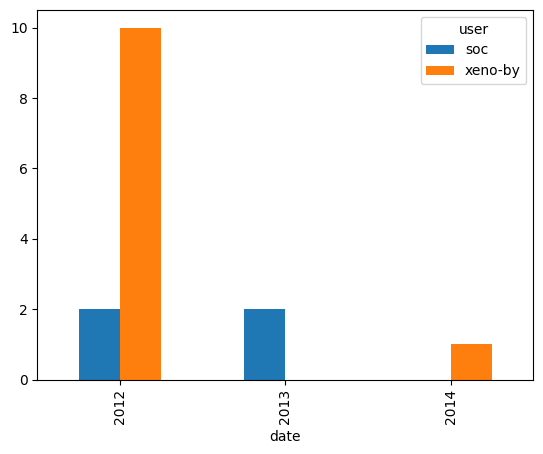

In [21]:
# Authors and the file we are interested in
authors = ['xeno-by', 'soc']
file = 'src/compiler/scala/reflect/reify/phases/Calculate.scala'

# Selecting the pull requests submitted by the authors, from the `data` DataFrame
by_author = data[data['user'].isin(authors)]

# Selecting the pull requests that affect the file
by_file = by_author[by_author['file'] == file]

# Grouping and counting the number of Pull Requests done by each user, each year
grouped = by_file.groupby(['user', by_file['date'].dt.year]).count()['pid'].reset_index()

# Transforming the data into a wide format
by_file_wide = grouped.pivot_table(index='date', columns='user', values='pid', fill_value=0 )

# Plotting the results
by_file_wide.plot(kind='bar')